# Twitter Topic Modeling and Network Analysis

In this notebook the code used to collect and analyize Tweets from Twitter.com is presented. The Tweets are pulled from the Twitter API using developer account credentials and pickled to disk. Once the data has been collected the mentions of other user accounts are seperated from the Tweets and the process of collecting Tweets is appied to all 100 user accounts. The user mentions inside these are seperated and used for network analysis. 

#### This notebook was run on a t2.2xlarge AWS instance 

### Install Packages

In [1]:
#Notebook was run on AWS so these installs were required
!pip install nltk
!pip install tweepy
!pip install yellowbrick
!pip install pyLDAvis
!pip install graphlab

    100% |████████████████████████████████| 1.4MB 445kB/s ta 0:00:011
  Running setup.py bdist_wheel for nltk ... done
  Stored in directory: /home/jovyan/.cache/pip/wheels/d1/ab/40/3bceea46922767e42986aef7606a600538ca80de6062dc266c
Successfully built nltk
You are using pip version 9.0.3, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
    100% |████████████████████████████████| 122kB 3.3MB/s ta 0:00:01
You are using pip version 9.0.3, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
    100% |████████████████████████████████| 245kB 2.2MB/s ta 0:00:011
You are using pip version 9.0.3, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
    100% |████████████████████████████████| 1.6MB 394kB/s eta 0:00:01
    100% |████████████████████████████████| 276kB 1.7MB/s ta 0:00:011
    100% |█████████████████████████

  Running setup.py bdist_wheel for future ... done
  Stored in directory: /home/jovyan/.cache/pip/wheels/bf/c9/a3/c538d90ef17cf7823fa51fc701a7a7a910a80f6a405bf15b1a
Successfully built pyLDAvis future
You are using pip version 9.0.3, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
  Could not find a version that satisfies the requirement graphlab (from versions: )
No matching distribution found for graphlab
You are using pip version 9.0.3, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


### Import packages

In [28]:
import pandas as pd
import numpy as np

import time
import tweepy
from tweepy import OAuthHandler 
from time import time

import string
import html
import nltk
import matplotlib as plt
import networkx as nx
import matplotlib.pyplot as plt

from sklearn.feature_extraction import text 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV

from yellowbrick.text import TSNEVisualizer

%matplotlib inline

### Aquire Tweets from the Twitter API

In [3]:
#Inspired by https://gist.github.com/yanofsky/5436496

consumer_key="JA5rlYX4AQk5E72ikNyDFXgAe"
consumer_secret="V2WJz7NSTIuCt9BmzZSBhqRk5D63PncNtir6b7HJMhDapzmBvL"
access_key="1034622988379803650-FIgLtjCpZcVMRenkKzIQBNvJilIBWk"
access_secret="OOTqcz7BIrNcUf9B3WnRasuSmjFQVHIhPgGMC7o0XvcTF"

def get_tweets(user_name):
    #initiate Tweepy OAuthHandler 
    auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_key, access_secret)
    api = tweepy.API(auth)
    #empty list to hold the tweets
    alltweets = []
    #the max tweets you can grab at once is 200, this is the first batch of 200
    new_tweets = api.user_timeline(screen_name = user_name, count=200)
    #save most recent tweets
    alltweets.extend(new_tweets)
    #save the id of the oldest tweet less one
    oldest = alltweets[-1].id - 1 
    #keep grabbing tweets until there are no tweets left to grab
    while len(new_tweets) > 0:
#         print("getting tweets before %s" % (oldest))
#         time.sleep(0.0)#SLOW down
        #all subsiquent requests use the max_id param to prevent duplicates
        new_tweets = api.user_timeline(screen_name = user_name, count=200,max_id=oldest)
        #save most recent tweets
        alltweets.extend(new_tweets)
        #update the id of the oldest tweet less one
        oldest = alltweets[-1].id - 1
        
    outtweets =         [tweet.text for tweet in alltweets]
    
    print(user_name, len(outtweets))       
    
    return outtweets

## Seperate the User Mentions from the Tweet Text Body

In [4]:
#copyright DataSnek 
def get_mentions(user, number_mentions):
    #get the tweets with the "get_tweets" function 
    tweets = get_tweets(user)
    #use this to remove punct
    translator=str.maketrans('','',string.punctuation)
    #all mentions empty dictionary
    tweets_dict = {}
    #list to store the mentions
    mention_list = []
    for text in tweets:
        text_split = text.split()
        for item in text_split:
            #grabs the words that start with @ because this indicates a username 
            if item.startswith('@'):
                #remove all html elements
                html.unescape(item)
                #remove all punctuation like 's or ...
                item = item.translate(translator)
                item = item.replace("'S", "")
                item = item.replace("...", "")
                #since Twitter users often refer to themselves in the Tweet we remove these words 
                if item == user:
                    pass
                #If the str is non-existent then pass
                elif item == '':
                    pass
                #else store the item
                else:
                    mention_list.append(item)
    #use NLTK frequency distribution to get most freqently mentioned users                
    fd1 = nltk.FreqDist(mention_list)
    #Make a graph of the most common mentions 
    fd1.plot(30,cumulative=False)
    #make a list of the most common mentions
    list_top = list(fd1.most_common(n=number_mentions))
    #put tweets into dict with user as key
    tweets_dict[user] = tweets 
   
    return list_top, tweets_dict

## Collect Tweets and Network Info from Greater Network

In [5]:
#copyright DataSnek
def network_and_tweets(user_name, user_list, depth):
    net_dict = {}
    tweet_dict = {}
    net_dict[user_name] = user_list
    for user_name in user_list:
        try:
            user_mentions, tweet_s = get_mentions(user_name[0], depth)
            net_dict[user_name[0]] = user_mentions
            tweet_dict.update(tweet_s)
        #handle exception and return the error and username
        except Exception as e:
            print(user_name, e)

    return net_dict, tweet_dict

## Graph Network Info as NetworkX Spring Graph

In [33]:
#copyright DataSnek
def graph_network_spring(user_name, net_dict):
    g = nx.Graph()
    for key in net_dict.keys():
        for item in net_dict[key]:
            g.add_edge(key, item[0],weight=item[1])
    D = nx.ego_graph(g, user_name, radius=1, center=True)
    plt.figure(figsize=(24,12))
    nx.draw_spring(D, alpha=0.5, node_size=40, font_size=12, node_color='r' )

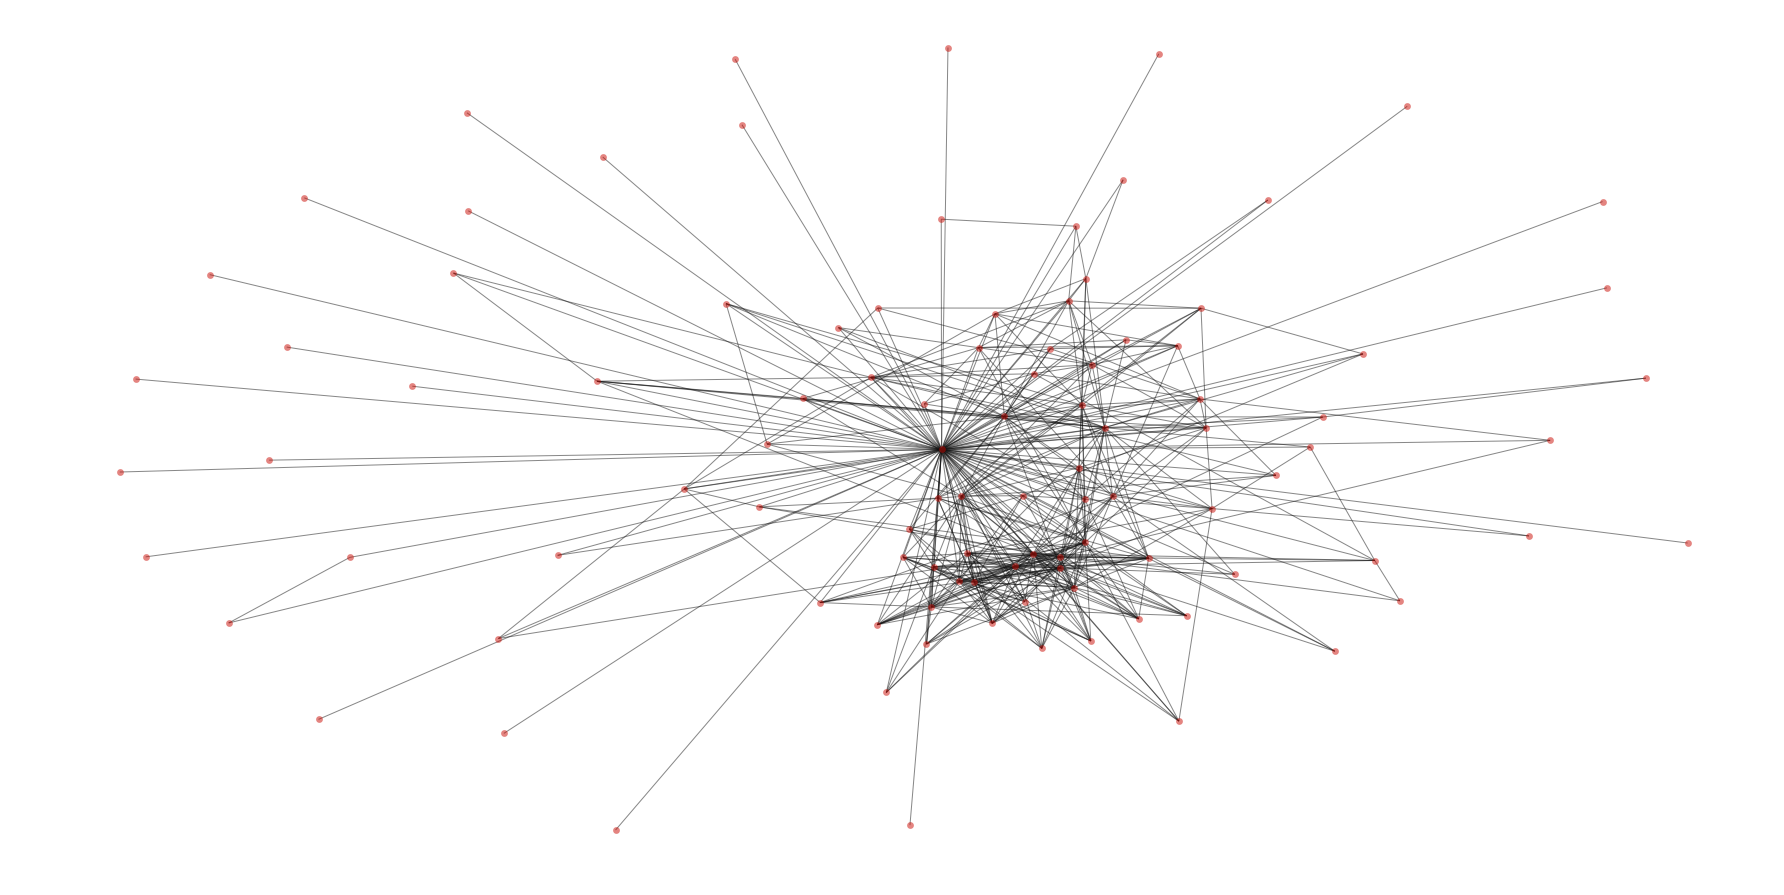

In [34]:
graph_network_spring("AlexWhitcomb", alex_net_dict)

## Graph Network Info as NetworkX Force Directed Ego Graph

AlexWhitcomb 3178


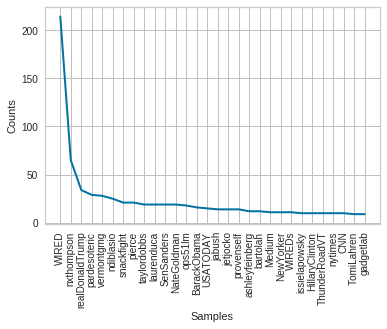

In [6]:
alex_ment, alex_tweets = get_mentions('AlexWhitcomb', 100)

WIRED 3199


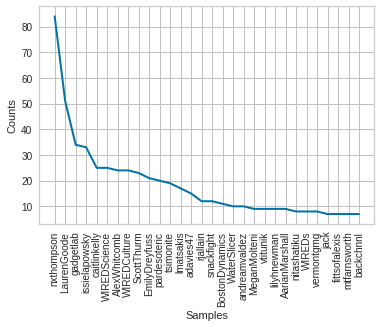

nxthompson 3212


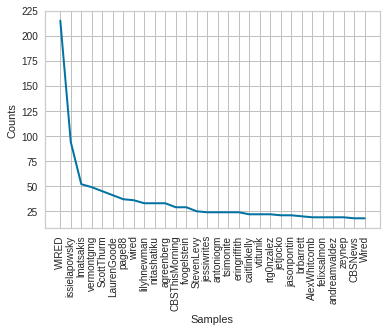

realDonaldTrump 3239


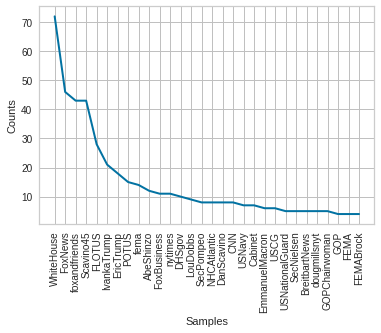

pardesoteric 337


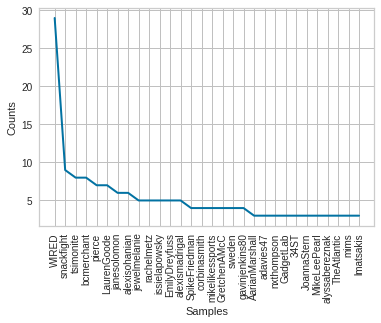

vermontgmg 3209


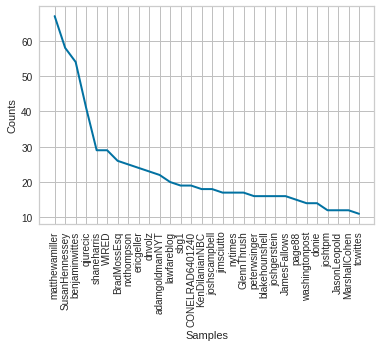

('ndiblasio', 25) Not authorized.
snackfight 3190


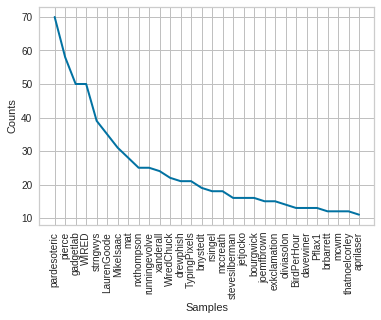

pierce 1253


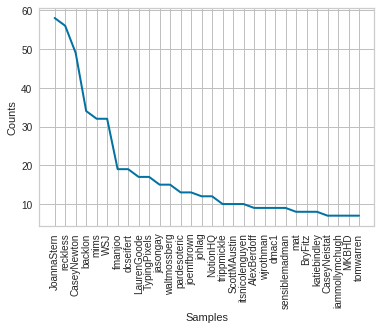

taylordobbs 3199


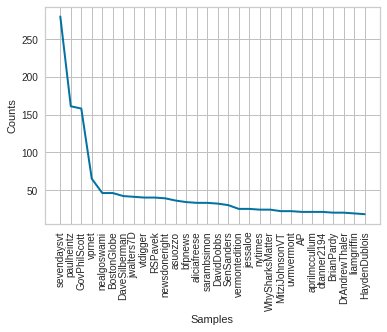

laurenduca 3224


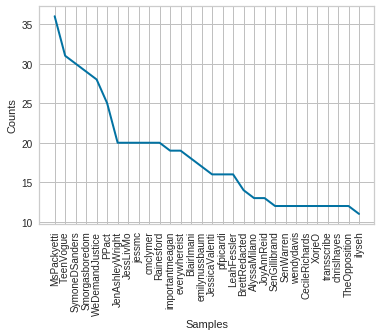

SenSanders 3227


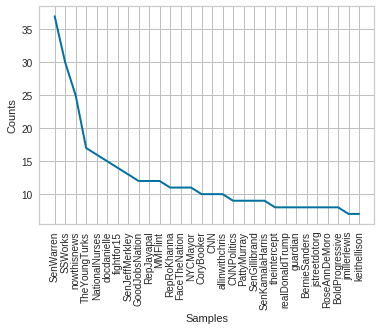

NateGoldman 3213


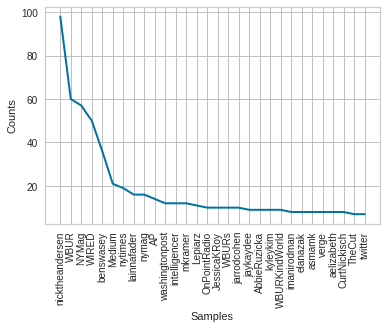

ops51lm 1198


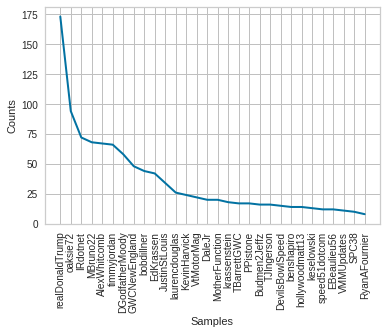

BarackObama 3229


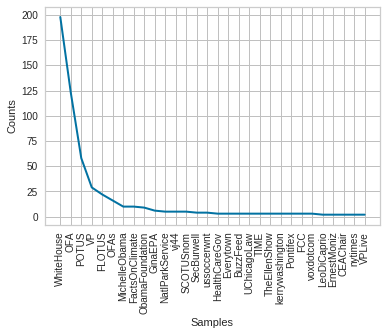

USATODAY 3208


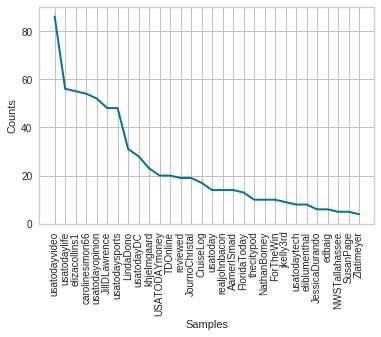

jabush 3200


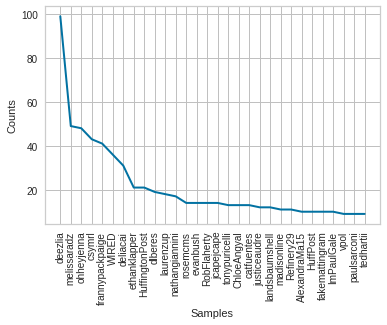

jetjocko 3234


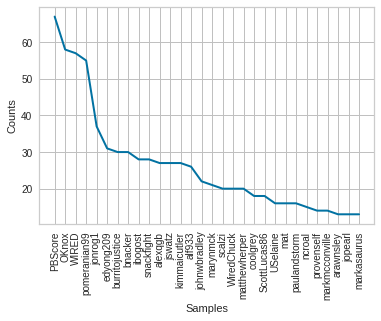

provenself 3214


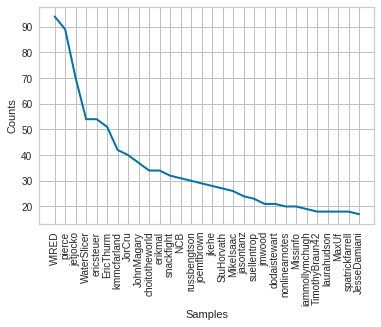

ashleyfeinberg 3239


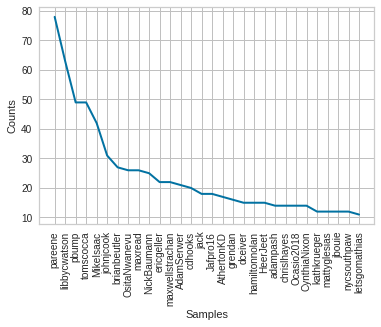

bartolah 3197


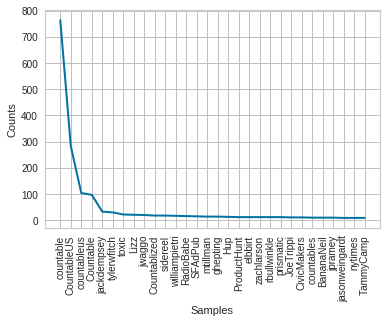

Medium 3207


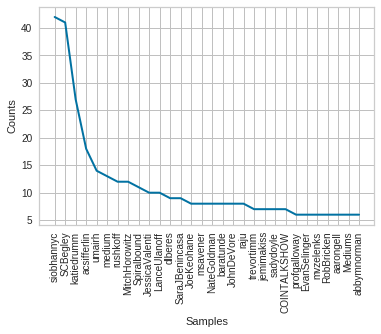

NewYorker 3219


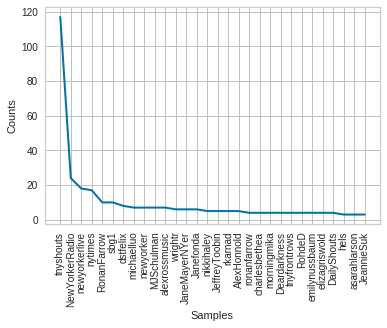

WIREDs 1


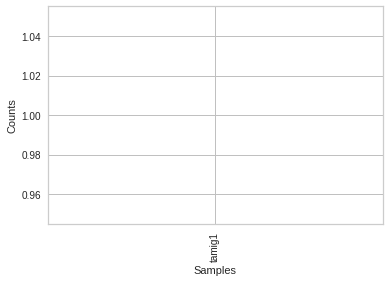

issielapowsky 3238


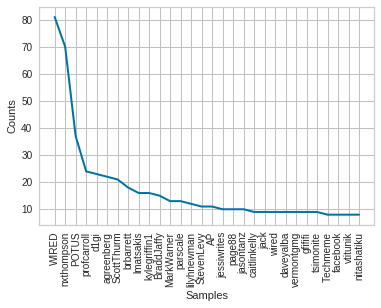

HillaryClinton 3245


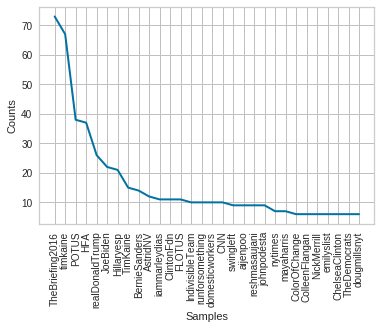

ThunderRoadVT 1104


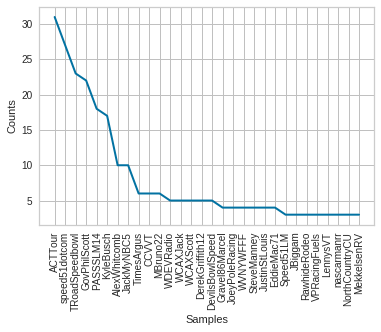

nytimes 3244


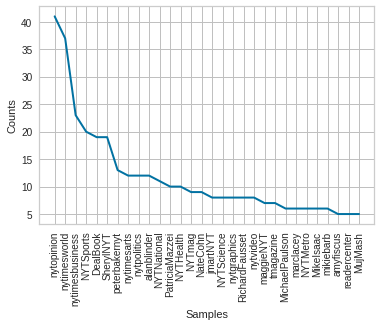

CNN 3224


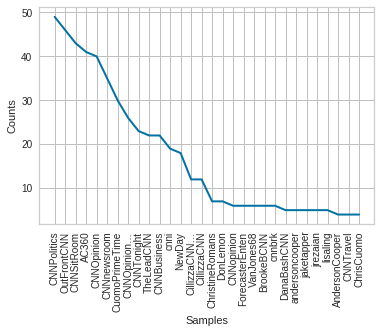

TomiLahren 3207


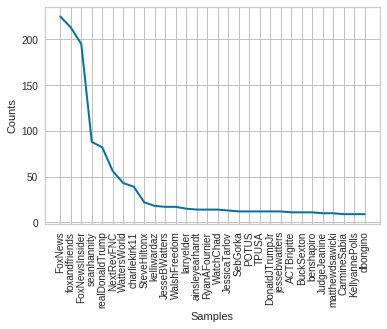

gadgetlab 3203


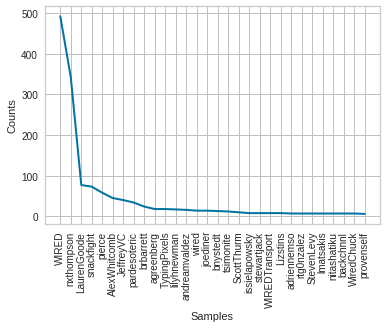

stewartjack 429


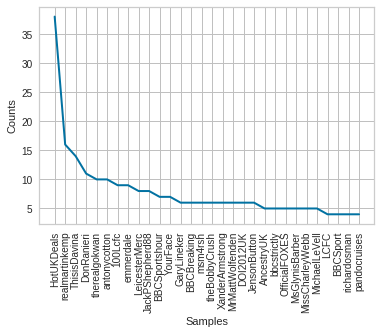

BrentSum 2166


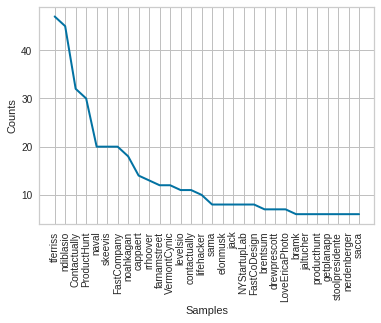

FoxNews 3236


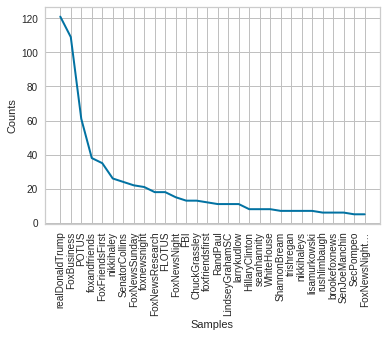

KinseyCrowley 126


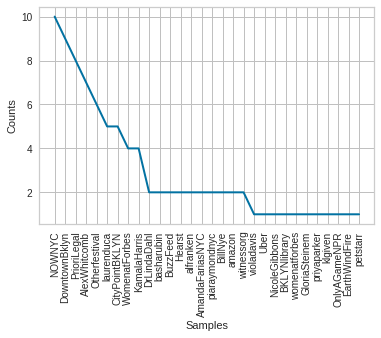

Melanieny5404 3193


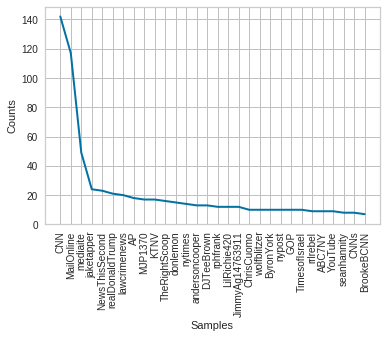

jessnthecity 3200


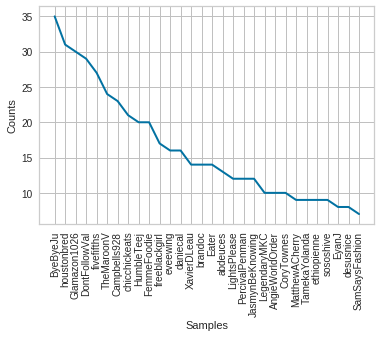

JoeBerkowitz 1486


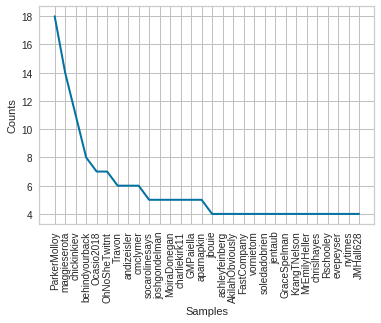

kylegriffin1 3202


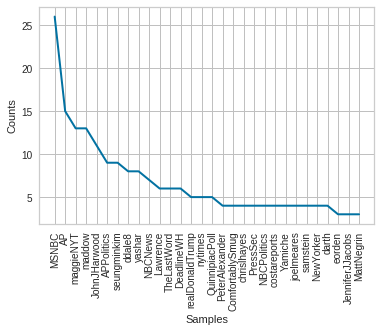

WiredChuck 3197


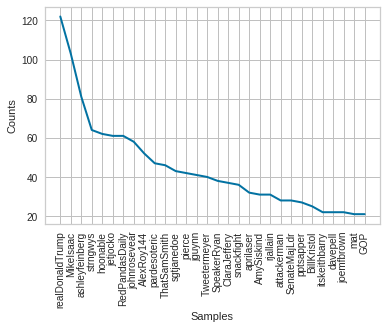

Trevornoah 3188


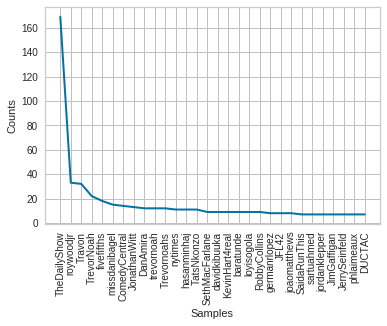

mtfarnsworth 3214


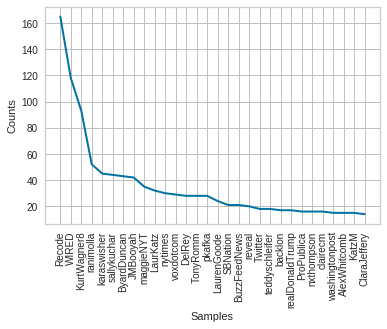

WIREDScience 3236


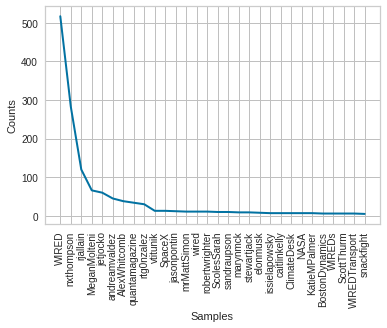

SenJohnMcCain 3221


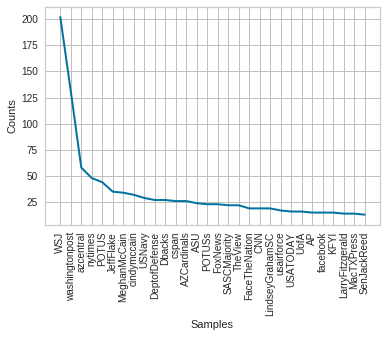

onstagevoice 3147


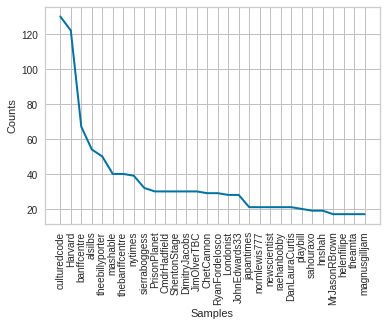

AMomentITL 393


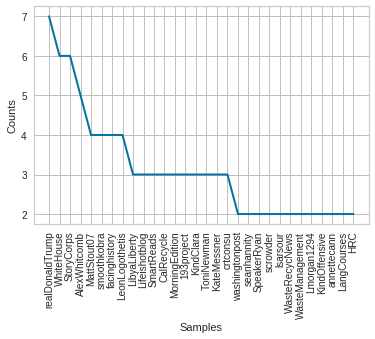

andreamvaldez 1820


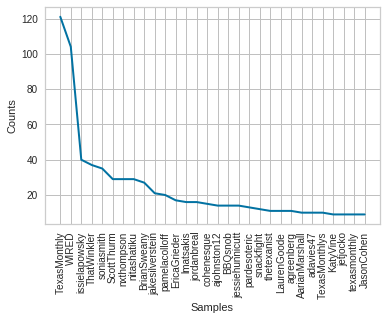

washingtonpost 3245


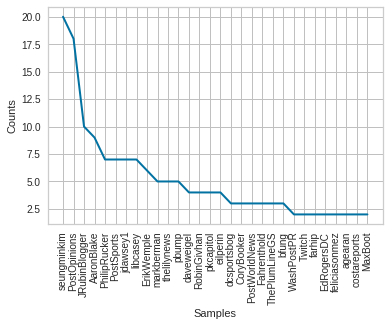

mrMattSimon 2395


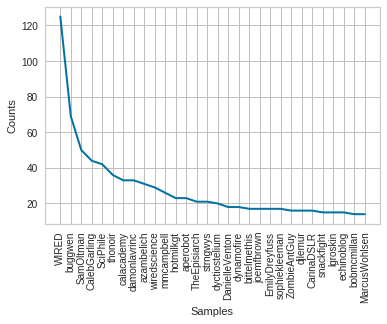

indumania 3189


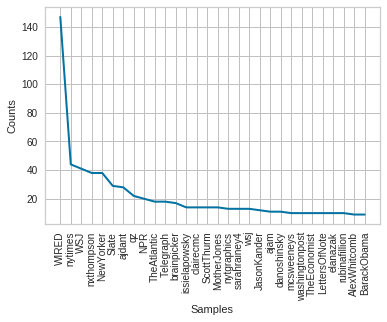

selenagomez 3198


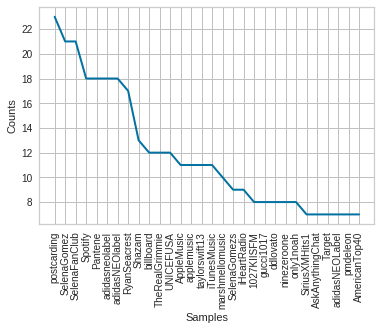

whyisjake 3230


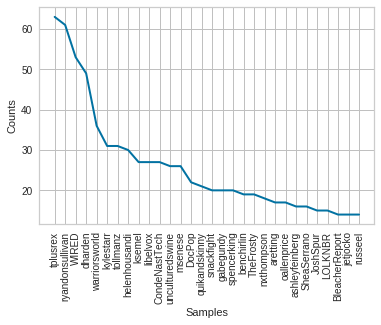

adavies47 3217


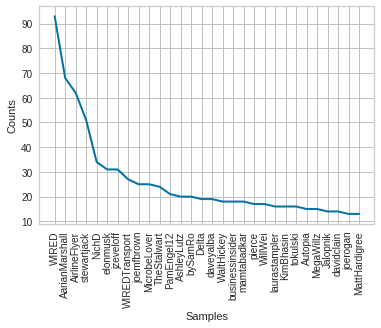

SenatorLeahy 3231


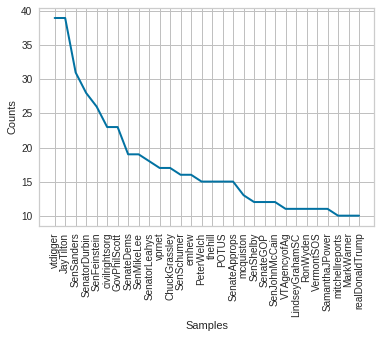

antoniogm 3206


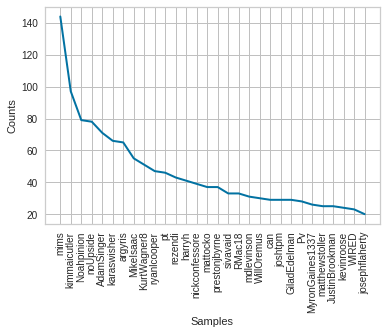

JohnMayer 2684


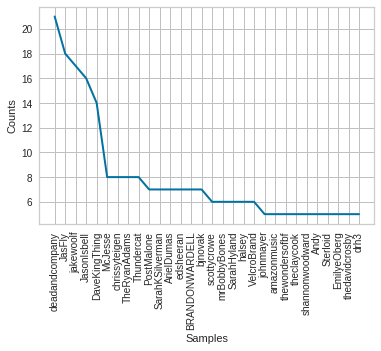

mabyillah 3201


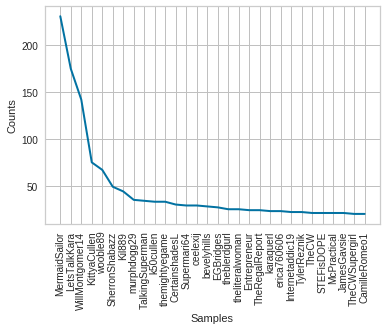

NASA 3225


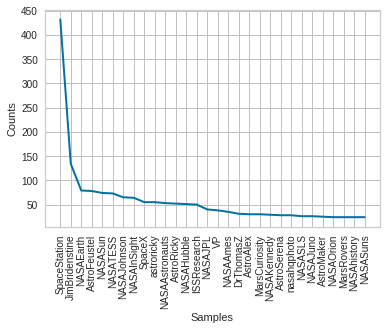

EmmaGreyEllis 272


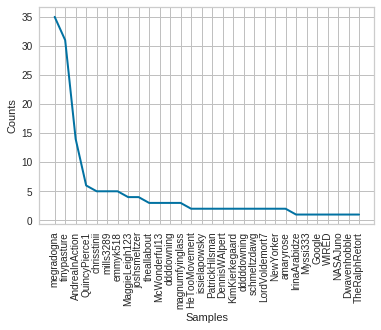

('DigitalSummits', 4) [{'message': 'Rate limit exceeded', 'code': 88}]
('Eagles', 4) [{'message': 'Rate limit exceeded', 'code': 88}]
('SpeakerRyan', 4) [{'message': 'Rate limit exceeded', 'code': 88}]
('elonmusk', 4) [{'message': 'Rate limit exceeded', 'code': 88}]
('AarianMarshall', 4) [{'message': 'Rate limit exceeded', 'code': 88}]
('JeffFlake', 4) [{'message': 'Rate limit exceeded', 'code': 88}]
('brbarrett', 4) [{'message': 'Rate limit exceeded', 'code': 88}]
('DavidDobbs', 4) [{'message': 'Rate limit exceeded', 'code': 88}]
('MikeyBlair', 4) [{'message': 'Rate limit exceeded', 'code': 88}]
('MelanieHannah', 4) [{'message': 'Rate limit exceeded', 'code': 88}]
('DebLynnSenger', 4) [{'message': 'Rate limit exceeded', 'code': 88}]
('iandavisian1', 4) [{'message': 'Rate limit exceeded', 'code': 88}]
('SuppressThis', 4) [{'message': 'Rate limit exceeded', 'code': 88}]
('OfficialSUtwit', 4) [{'message': 'Rate limit exceeded', 'code': 88}]
('tedcruz', 3) [{'message': 'Rate limit exceede

In [8]:
alex_net_dict, alex_tweets = network_and_tweets("AlexWhitcomb", alex_ment, 100)

57

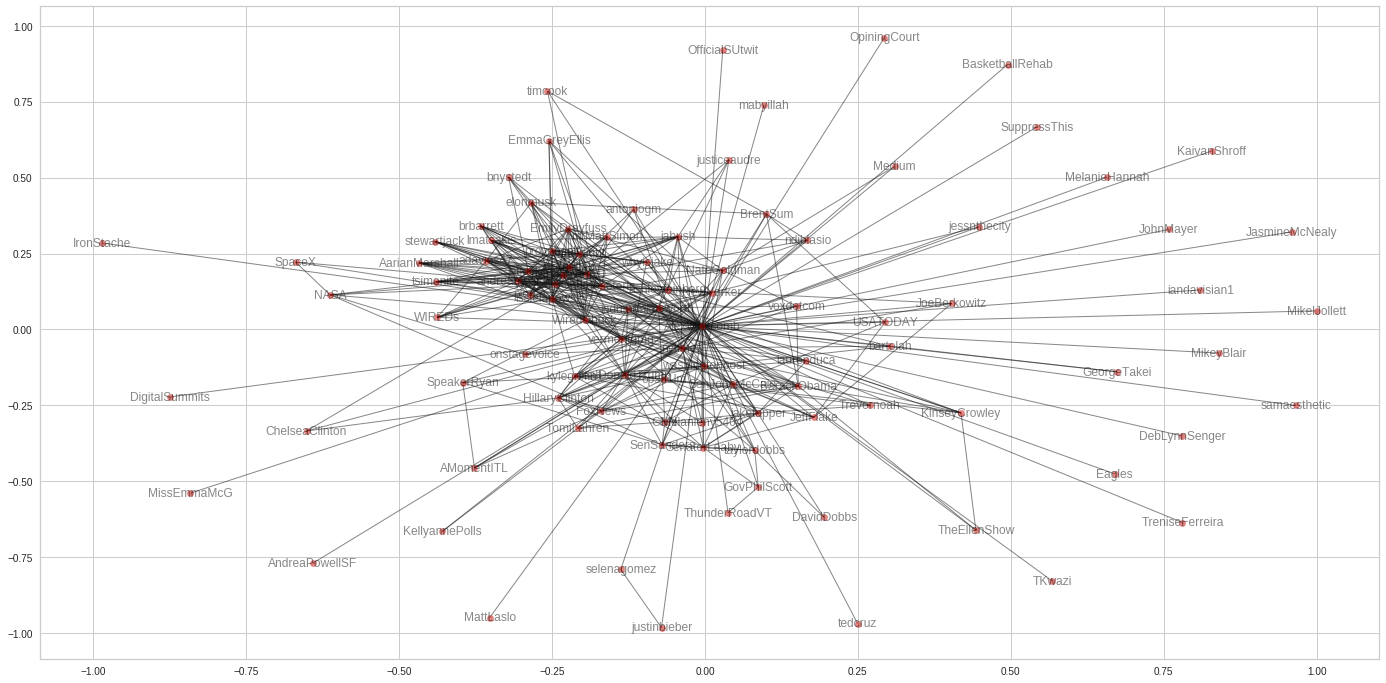

In [30]:
graph_network("AlexWhitcomb", alex_net_dict)

In [20]:
def make_tweets_list(tweets_dictionary):
    all_da_tweets = []
    for key in tweets_dictionary.keys():
        for sent in tweets_dictionary[key]:
            all_da_tweets.append(sent)
    return all_da_tweets
    

In [21]:
cv_alex = make_tweets_list(alex_tweets)

In [ ]:
box_peeps = []
for name in alex_ment[:4]:
    box_peeps.append(name[0])
    

In [ ]:
box_peeps

In [ ]:
newest_list = []
for x[0] in new_list[0]:
    newest_list.append(x[0])

In [ ]:
def save_obj(obj, name ):
    with open('obj/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open('obj/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)


In [23]:
#copyright DataSnek
def graph_network(user_name, net_dict):
    g = nx.Graph()
    for key in net_dict.keys():
        for item in net_dict[key]:
            g.add_edge(key, item[0],weight=item[1])
    D = nx.ego_graph(g, user_name, radius=1, center=True)
    plt.figure(figsize=(24,12))
    nx.draw_networkx(D, alpha=0.5, node_size=40, font_size=12, node_color='r' )

In [ ]:
tsne_vis(newest_list, box_peeps)

## t-SNE Analysis 

In [17]:
# Graphing tool for t-SNE
def tsne_vis(corpus):
    plt.figure
    tfidf  = TfidfVectorizer()
    tsne = TSNEVisualizer()
    docs   = tfidf.fit_transform(corpus)
    # Create the visualizer and draw the vectors
    tsne.fit(docs)
    tsne.poof()

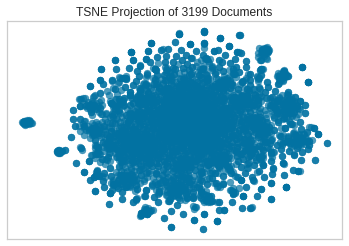

WIRED


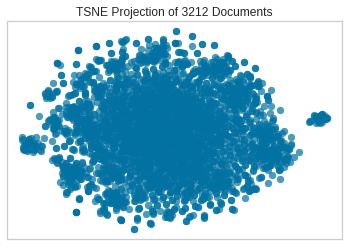

nxthompson


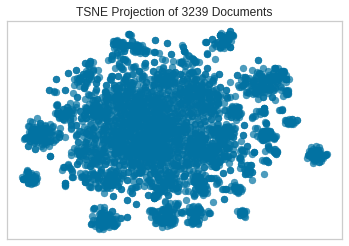

realDonaldTrump


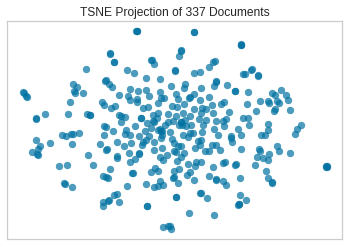

pardesoteric


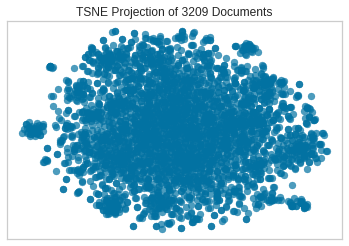

vermontgmg
('ndiblasio', 25) 'ndiblasio'


In [18]:
for user in alex_ment[:6]:   
    try:
        tsne_vis(alex_tweets[user[0]])
        print(user[0])
        #handle exception and return the error and username
    except Exception as e:
        print(user, e)


In [ ]:
tsne_vis(cv_alex)

In [ ]:
len(alex_tweets["AlexWhitcomb"])

## Gater the Text Bodies and Perform TFIDF

In [40]:
def make_tweets_list(tweets_dictionary):
    all_da_tweets = []
    for key in tweets_dictionary.keys():
        for sent in tweets_dictionary[key]:
            all_da_tweets.append(sent)
    return all_da_tweets
    

In [41]:
cv_alex = make_tweets_list(alex_tweets)

In [42]:
my_additional_stop_words = ['http', 'https', 'rt', 'amp', 'drdisrespect']
stop_words = text.ENGLISH_STOP_WORDS.union(my_additional_stop_words)

tfidf = TfidfVectorizer()

td = tfidf.fit_transform(cv_alex)

tf_feature_names = tf_vectorizer.get_feature_names()

In [39]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

## LatentDirichletAllocation

In [48]:
#batch_siz
batch = 2000
#n_components
nc = 20
#total_samples
ts = 4000
#learning_offset
lo = 50
n_top_words = 20


lda = LatentDirichletAllocation(batch_size=batch, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=1,
             learning_method='batch', learning_offset=lo,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=nc, n_jobs=8, n_topics=None, perp_tol=0.1,
             random_state=0, topic_word_prior=None,
             total_samples=ts, verbose=0)
# def lda_k_search(vect_corpus, k):
    
lda.fit(td)
print_top_words(lda, tf_feature_names, n_top_words)

OSError: [Errno 28] No space left on device

In [ ]:
import graphlab as gl
import pandas as pd
import pyLDAvis
import pyLDAvis.graphlab

pyLDAvis.enable_notebook()

In [ ]:
import pyLDAvis
import pyLDAvis.gensim
corpus = tf
lexicon = tf_feature_names


lda = LatentDirichletAllocation(batch_size=batch, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=1,
             learning_method='batch', learning_offset=lo,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=nc, n_jobs=8, n_topics=None, perp_tol=0.1,
             random_state=0, topic_word_prior=None,
             total_samples=ts, verbose=0)

data = pyLDAvis.gensim.prepare(lda, corpus, lexicon)

In [ ]:
#batch_siz
batch = 2000
#n_components
nc = 10
#total_samples
ts = 4000
#learning_offset
lo = 50
n_top_words = 20


lda = LatentDirichletAllocation(batch_size=batch, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=1,
             learning_method='batch', learning_offset=lo,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=nc, n_jobs=8, n_topics=None, perp_tol=0.1,
             random_state=0, topic_word_prior=None,
             total_samples=ts, verbose=0)
# def lda_k_search(vect_corpus, k):
    
lda.fit(tf)
print_top_words(lda, tf_feature_names, n_top_words)

In [ ]:
#batch_siz
batch = 2000
#n_components
nc = 30
#total_samples
ts = 4000
#learning_offset
lo = 50
n_top_words = 20


lda = LatentDirichletAllocation(batch_size=batch, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=1,
             learning_method='batch', learning_offset=lo,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=nc, n_jobs=8, n_topics=None, perp_tol=0.1,
             random_state=0, topic_word_prior=None,
             total_samples=ts, verbose=0)
# def lda_k_search(vect_corpus, k):
    
lda.fit(tf)
print_top_words(lda, tf_feature_names, n_top_words)

In [ ]:
#batch_siz
batch = 2000
#n_components
nc = 20
#total_samples
ts = 4000
#learning_offset
lo = 80
n_top_words = 20


lda = LatentDirichletAllocation(batch_size=batch, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=1,
             learning_method='batch', learning_offset=lo,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=nc, n_jobs=8, n_topics=None, perp_tol=0.1,
             random_state=0, topic_word_prior=None,
             total_samples=ts, verbose=0)
# def lda_k_search(vect_corpus, k):
    
lda.fit(tf)
print_top_words(lda, tf_feature_names, n_top_words)

In [ ]:
#batch_siz
batch = 2000
#n_components
nc = 30
#total_samples
ts = 4000
#learning_offset
lo = 50
n_top_words = 20


lda = LatentDirichletAllocation(batch_size=batch, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=1,
             learning_method='batch', learning_offset=lo,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=nc, n_jobs=8, n_topics=None, perp_tol=0.1,
             random_state=0, topic_word_prior=None,
             total_samples=ts, verbose=0)
# def lda_k_search(vect_corpus, k):
    
lda.fit(tf)
print_top_words(lda, tf_feature_names, n_top_words)

In [ ]:
#batch_siz
batch = 5000
#n_components
nc = 20
#total_samples
ts = 4000
#learning_offset
lo = 50
n_top_words = 20


lda = LatentDirichletAllocation(batch_size=batch, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=1,
             learning_method='batch', learning_offset=lo,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=nc, n_jobs=8, n_topics=None, perp_tol=0.1,
             random_state=0, topic_word_prior=None,
             total_samples=ts, verbose=0)
# def lda_k_search(vect_corpus, k):
    
lda.fit(tf)
print_top_words(lda, tf_feature_names, n_top_words)

In [ ]:
d

In [ ]:
tsne_vis(cv_alex)

In [ ]:
# Create the visualizer and draw the vectors
tsne = TSNEVisualizer()
tsne.fit(docs)
tsne.poof()

In [ ]:
from sklearn.feature_extraction import text 
my_additional_stop_words = ['http', 'https', 'rt', 'amp', 'drdisrespect']
stop_words = text.ENGLISH_STOP_WORDS.union(my_additional_stop_words)

from __future__ import print_function
from time import time


from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

n_samples = 2000
n_features = 3000
n_components = 20
n_top_words = 20
learning_method = 'batch'


def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

print("Loading dataset...")
t0 = time()
# dataset = 
data_samples = all_da_tweets
print("done in %0.3fs." % (time() - t0))

print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,
                                max_features=n_features,
                                stop_words=stop_words)
t0 = time()
tf = tf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))
print()

# Fit the NMF model
print("Fitting the NMF model (Frobenius norm) with tf-idf features, "
      "n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
t0 = time()
nmf = NMF(n_components=n_components, random_state=1,
          alpha=.1, l1_ratio=.5).fit(tfidf)
print("done in %0.3fs." % (time() - t0))

print("\nTopics in NMF model (Frobenius norm):")
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)

# Fit the NMF model
print("Fitting the NMF model (generalized Kullback-Leibler divergence) with "
      "tf-idf features, n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
t0 = time()
nmf = NMF(n_components=n_components, random_state=1,
          beta_loss='kullback-leibler', solver='mu', max_iter=1000, alpha=.1,
          l1_ratio=.5).fit(tfidf)
print("done in %0.3fs." % (time() - t0))

print("\nTopics in NMF model (generalized Kullback-Leibler divergence):")
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)

print("Fitting LDA models with tf features, "
      "n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
lda = LatentDirichletAllocation(batch_size=2000, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=1,
             learning_method='batch', learning_offset=55.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=n_components, n_jobs=1, n_topics=None, perp_tol=0.1,
             random_state=0, topic_word_prior=None,
             total_samples=100000.0, verbose=0)

    
t0 = time()
lda.fit(tf)
print("done in %0.3fs." % (time() - t0))

print("\nTopics in LDA model:")
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)